# **Notebook 2a**: Mask R-CNN

<span style="font-size: 1.5rem;">By **Alison Attard**</span>

## Section 0: MetaData & Configuration

In [123]:


import os
import sys
import json
import time
import random
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import matplotlib.patches as patches
from PIL import Image
import cv2


In [124]:

COURSE = "ARI3129"
TASK = "Task 2a - Object Detection"
STUDENT = "Alison Attard"
DETECTOR_NAME = "maskrcnn_resnet50_fpn"
ATTRIBUTE_FOCUS = "sign_type"

SEED = 3129

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

print("reproducibility")
print("fixed seed: {}".format(SEED))
print("deterministic: true")


reproducibility
fixed seed: 3129
deterministic: true


In [125]:
# path configuration
REPO_ROOT = Path.cwd()
DATASET_ROOT = REPO_ROOT / "dataset" / "COCO-based_COCO"
WORK_DIR = REPO_ROOT / "work_dirs" / "{}_{}".format(DETECTOR_NAME, ATTRIBUTE_FOCUS)
CHECKPOINT_DIR = WORK_DIR / "checkpoints"
TENSORBOARD_DIR = WORK_DIR / "logs"
RESULTS_DIR = WORK_DIR / "results"

for directory in [CHECKPOINT_DIR, TENSORBOARD_DIR, RESULTS_DIR]:
    os.makedirs(directory, exist_ok=True)

print("\npath configuration")
print("dataset root: {}".format(DATASET_ROOT))
print("work directory: {}".format(WORK_DIR))
print("checkpoint directory: {}".format(CHECKPOINT_DIR))
print("results directory: {}".format(RESULTS_DIR))


path configuration
dataset root: /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/dataset/COCO-based_COCO
work directory: /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/maskrcnn_resnet50_fpn_sign_type
checkpoint directory: /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/maskrcnn_resnet50_fpn_sign_type/checkpoints
results directory: /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/maskrcnn_resnet50_fpn_sign_type/results


## Section 1: Environment Setup (PyTorch + Logging)

In [126]:
# logging setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("training device: {}".format(device))

if torch.cuda.is_available():
    print("cuda available: true")
    print("gpu name: {}".format(torch.cuda.get_device_name(0)))
    print("gpu memory: {:.2f} gb".format(torch.cuda.get_device_properties(0).total_memory / 1e9))
else:
    print("cuda available: false")

print("torch version: {}".format(torch.__version__))
print("torchvision version: {}".format(torchvision.__version__))

writer = SummaryWriter(str(TENSORBOARD_DIR))
print("tensorboard initialized")
print("view logs with: tensorboard --logdir {}".format(TENSORBOARD_DIR))

training device: cpu
cuda available: false
torch version: 2.9.0
torchvision version: 0.24.0
tensorboard initialized
view logs with: tensorboard --logdir /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/maskrcnn_resnet50_fpn_sign_type/logs


In [127]:

# training hyperparameters
NUM_EPOCHS = 8
BATCH_SIZE = 8   
LEARNING_RATE = 0.001  
WEIGHT_DECAY = 0.0005
CONFIDENCE_THRESHOLD = 0.3
SKIP_VISUALIZATIONS = False  # Set to True to skip visualizations during training

# Image size configuration
TARGET_IMAGE_SIZE = 512
MIN_IMAGE_SIZE = 224

print("\ntraining hyperparameters")
print("epochs: {}".format(NUM_EPOCHS))
print("batch size: {}".format(BATCH_SIZE))
print("learning rate: {}".format(LEARNING_RATE))
print("target image size: {}x{}".format(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE))
print("weight decay: {}".format(WEIGHT_DECAY))


training hyperparameters
epochs: 8
batch size: 8
learning rate: 0.001
target image size: 512x512
weight decay: 0.0005


## Section 2: Dataset Validation 

In [128]:

ANNOTATIONS_DIR = DATASET_ROOT / "annotations"
IMAGES_DIR = DATASET_ROOT / "images"

TRAIN_ANNOT = ANNOTATIONS_DIR / "train.json"
VAL_ANNOT = ANNOTATIONS_DIR / "val.json"
TEST_ANNOT = ANNOTATIONS_DIR / "test.json"

TRAIN_IMGS = IMAGES_DIR / "train"
VAL_IMGS = IMAGES_DIR / "val"
TEST_IMGS = IMAGES_DIR / "test"

paths_to_check = {
    "train annotations": TRAIN_ANNOT,
    "val annotations": VAL_ANNOT,
    "test annotations": TEST_ANNOT,
    "train images": TRAIN_IMGS,
    "val images": VAL_IMGS,
    "test images": TEST_IMGS,
}

print("validating dataset paths")
all_valid = True
for name, path in paths_to_check.items():
    exists = path.exists()
    status = "found" if exists else "NOT FOUND"
    print("{}: {}".format(name, status))
    if not exists:
        all_valid = False

if all_valid:
    print("all paths validated successfully")
else:
    print("warning: some paths missing")


validating dataset paths
train annotations: found
val annotations: found
test annotations: found
train images: found
val images: found
test images: found
all paths validated successfully


In [129]:
# load COCO annotations
print("\nloading COCO annotations")

def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

# analyze annotation distribution across classes
train_coco = load_coco_json(TRAIN_ANNOT)
val_coco = load_coco_json(VAL_ANNOT)
test_coco = load_coco_json(TEST_ANNOT)

coco_train_gt = COCO(str(TRAIN_ANNOT))
coco_val_gt = COCO(str(VAL_ANNOT))
coco_test_gt = COCO(str(TEST_ANNOT))

def get_dataset_stats(coco_data, split_name):
    num_images = len(coco_data.get("images", []))
    num_annotations = len(coco_data.get("annotations", []))
    categories = coco_data.get("categories", [])
    class_names = {cat["id"]: cat["name"] for cat in categories}
    num_classes = len(class_names) + 1
    
    print("\n{} split".format(split_name))
    print("images: {}".format(num_images))
    print("annotations: {}".format(num_annotations))
    print("classes: {}".format(num_classes))
    print("class names: {}".format(list(class_names.values())))
    
    return {
        "num_images": num_images,
        "num_annotations": num_annotations,
        "num_classes": num_classes,
        "class_names": class_names,
    }

train_stats = get_dataset_stats(train_coco, "Train")
val_stats = get_dataset_stats(val_coco, "Validation")
test_stats = get_dataset_stats(test_coco, "Test")

class_names = train_stats["class_names"]
num_classes = train_stats["num_classes"]

print("\nclass mapping")
for class_id in sorted(class_names.keys()):
    print("class {}: {}".format(class_id, class_names[class_id]))



loading COCO annotations
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Train split
images: 483
annotations: 527
classes: 7
class names: ['Blind-Spot Mirror (Convex)', 'No Entry (One Way)', 'No Through Road (T-Sign)', 'Pedestrian Crossing', 'Roundabout Ahead', 'Stop']

Validation split
images: 88
annotations: 92
classes: 7
class names: ['Blind-Spot Mirror (Convex)', 'No Entry (One Way)', 'No Through Road (T-Sign)', 'Pedestrian Crossing', 'Roundabout Ahead', 'Stop']

Test split
images: 86
annotations: 93
classes: 7
class names: ['Blind-Spot Mirror (Convex)', 'No Entry (One Way)', 'No Through Road (T-Sign)', 'Pedestrian Crossing', 'Roundabout Ahead', 'Stop']

class mapping
class 1: Blind-Spot Mirror (Convex)
class 2: No Entry (One Way)
class 3: No Through Road (T-Sign)
class 4: Pedestria

## Section 3: Model Setup and Configuration (PyTorch)


## Model Configuration: Mask R-CNN with ResNet-50 FPN Backbone

### Rationale for Architecture Choice

Mask R-CNN is chosen for this task because:

1. **Two-stage detector**: Provides both bounding box localization and instance segmentation
2. **ResNet-50 backbone**: Offers good balance between accuracy and computational cost
3. **Feature Pyramid Network (FPN)**: Handles multi-scale objects effectively
4. **COCO pretrained weights**: Provides strong initialization from large-scale dataset
5. **Stable implementation**: torchvision implementation is well-documented and production-ready

### Key Benefits for Traffic Sign Detection

- Instance segmentation enables precise sign boundaries
- Multi-scale feature handling captures signs at various distances
- Transfer learning from COCO reduces training time
- Proven performance on object detection benchmarks

In [130]:

from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

print("loading mask r-cnn with resnet-50 fpn backbone")
weights = MaskRCNN_ResNet50_FPN_Weights.COCO_V1
model = maskrcnn_resnet50_fpn(weights=weights)
model = model.to(device)
print("pretrained model loaded")

# freezing backbone & RPN
print("freezing backbone parameters")
for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.rpn.parameters():
    param.requires_grad = False

print("modifying detection and mask heads for {} classes".format(num_classes))
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

print("model head modified for {} classes".format(num_classes))

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_mb = (total_params * 4) / (1024 * 1024)

print("model parameters")
print("total: {:,}".format(total_params))
print("trainable: {:,}".format(trainable_params))
print("estimated size: {:.2f} mb".format(model_size_mb))




loading mask r-cnn with resnet-50 fpn backbone
pretrained model loaded
freezing backbone parameters
modifying detection and mask heads for 7 classes
model head modified for 7 classes
model parameters
total: 43,949,305
trainable: 16,556,074
estimated size: 167.65 mb


### Data Augmentation

In [ ]:

from torchvision import transforms
from PIL import ExifTags

from PIL import Image, ImageOps

def fix_exif_orientation(image):
    """Fix EXIF orientation using PIL's built-in method"""
    try:
        # handles orientation based on EXIF data
        image = ImageOps.exif_transpose(image)
        if image is None:
            return image
    except (AttributeError, KeyError, IndexError):
        pass
    return image

class Compose:
    """Compose multiple transforms"""
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor:
    """Convert PIL Image to tensor"""
    def __call__(self, image, target):
        image = transforms.functional.to_tensor(image)
        return image, target

class ConvertImageDtype:
    """Convert tensor to specific dtype"""
    def __init__(self, dtype):
        self.dtype = dtype
    
    def __call__(self, image, target):
        return image.to(self.dtype), target

class RandomHorizontalFlip:
    """Random horizontal flip with bbox adjustment"""
    def __init__(self, prob=0.5):
        self.prob = prob
    
    def __call__(self, image, target):
        if torch.rand(1) < self.prob:
            image = torchvision.transforms.functional.hflip(image)
            if "boxes" in target and target["boxes"].shape[0] > 0:
                boxes = target["boxes"]
                image_width = image.shape[-1]
                boxes[:, [0, 2]] = image_width - boxes[:, [2, 0]]
                target["boxes"] = boxes
            if "masks" in target and target["masks"].shape[0] > 0:
                target["masks"] = torch.flip(target["masks"], dims=[-1])
        return image, target

class ResizeSquare:
    
    # resize image to fixed square size (512x512 ideal, 224x224 minimum).
    # Pads with gray if image is smaller to maintain aspect ratio,
    
    def __init__(self, target_size=512):
        self.target_size = target_size
    
    def __call__(self, image, target):
        original_width, original_height = image.size
        
        # scale to fit image within target_size
        scale = self.target_size / max(original_width, original_height)
        
        new_width = int(original_width * scale)
        new_height = int(original_height * scale)
        
        image = image.resize((new_width, new_height), Image.BILINEAR)
        
        # square canvas with gray background
        canvas = Image.new('RGB', (self.target_size, self.target_size), color=(128, 128, 128))
        
        # padding to center image
        x_offset = (self.target_size - new_width) // 2
        y_offset = (self.target_size - new_height) // 2
        
        canvas.paste(image, (x_offset, y_offset))
        image = canvas

        if "boxes" in target and target["boxes"].shape[0] > 0:
            boxes = target["boxes"]
            boxes = boxes * scale 
            boxes[:, [0, 2]] += x_offset
            boxes[:, [1, 3]] += y_offset
            target["boxes"] = boxes
        
        if "masks" in target and target["masks"].shape[0] > 0:
            import torch.nn.functional as F
            
            # resize masks to new size
            masks = target["masks"].unsqueeze(0)
            resized_masks = F.interpolate(
                masks.float(), 
                size=(new_height, new_width), 
                mode='nearest'
            ).squeeze(0)
            
            padded_masks = torch.zeros((resized_masks.shape[0], self.target_size, self.target_size))
            padded_masks[:, y_offset:y_offset+new_height, x_offset:x_offset+new_width] = resized_masks
            
            target["masks"] = padded_masks
        
        return image, target


In [ ]:
# transforms with with img size 512
train_transforms = Compose([
    ResizeSquare(target_size=TARGET_IMAGE_SIZE),
    ToTensor(),
    ConvertImageDtype(torch.float32),
    RandomHorizontalFlip(prob=0.5),
])

val_transforms = Compose([
    ResizeSquare(target_size=TARGET_IMAGE_SIZE),
    ToTensor(),
    ConvertImageDtype(torch.float32),
])

print("data augmentation transforms configured (size: {}x{})".format(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE))


data augmentation transforms configured (size: 512x512)


In [134]:

# optimizer and scheduler

optimizer = optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=0.9,
    weight_decay=WEIGHT_DECAY
)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print("optimizer: SGD with momentum")
print("learning rate scheduler: StepLR (step_size=3, gamma=0.1)")


optimizer: SGD with momentum
learning rate scheduler: StepLR (step_size=3, gamma=0.1)


In [135]:
# dataset
class COCODataset(Dataset):
    """Custom PyTorch Dataset for COCO format data"""
    
    def __init__(self, coco_data, image_dir, transforms=None):
        self.coco_data = coco_data
        self.image_dir = Path(image_dir)
        self.transforms = transforms
        self.images = coco_data["images"]
        self.annotations = coco_data["annotations"]
        self.categories = {cat["id"]: cat["name"] for cat in coco_data["categories"]}
        
        # Build image_id -> annotations mapping
        self.image_to_anns = {}
        for ann in self.annotations:
            image_id = ann["image_id"]
            if image_id not in self.image_to_anns:
                self.image_to_anns[image_id] = []
            self.image_to_anns[image_id].append(ann)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_info = self.images[idx]
        image_id = img_info["id"]
        file_name = img_info["file_name"]
        
        image_path = self.image_dir / file_name
        image = Image.open(image_path).convert("RGB")
        
        # fix EXIF orientation
        # image = fix_exif_orientation(image)
        image = ImageOps.exif_transpose(image)
        if image is None:
            image = Image.open(image_path).convert("RGB")
        
        anns = self.image_to_anns.get(image_id, [])
        
        
        boxes = []
        labels = []
        
        for ann in anns:
            bbox = ann["bbox"]
            x, y, w, h = bbox
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)
        
        h, w = img_info["height"], img_info["width"]
        
        # Create masks from bboxes
        if boxes.shape[0] > 0:
            masks = torch.zeros((boxes.shape[0], h, w), dtype=torch.uint8)
            for i, box in enumerate(boxes):
                x1, y1, x2, y2 = box.int().tolist()
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(w, x2), min(h, y2)
                if x2 > x1 and y2 > y1:
                    masks[i, y1:y2, x1:x2] = 1
        else:
            masks = torch.zeros((0, h, w), dtype=torch.uint8)
        
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks.float() if masks.shape[0] > 0 else masks,
            "image_id": torch.tensor([image_id]),
        }
        
        if self.transforms:
            image, target = self.transforms(image, target)
        
        return image, target

print("COCODataset class defined")

COCODataset class defined


In [136]:

# datasets and dataloaders

print("\ncreating datasets and dataloaders")

train_dataset = COCODataset(train_coco, TRAIN_IMGS, transforms=train_transforms)
val_dataset = COCODataset(val_coco, VAL_IMGS, transforms=val_transforms)
test_dataset = COCODataset(test_coco, TEST_IMGS, transforms=val_transforms)

print("train dataset: {} images".format(len(train_dataset)))
print("val dataset: {} images".format(len(val_dataset)))
print("test dataset: {} images".format(len(test_dataset)))

def collate_fn(batch):
    return tuple(zip(*batch))
 
# num_workers=2 for faster data loading (if on GPU)
num_workers = 2 if torch.cuda.is_available() else 0

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

print("dataloaders created")
print("train batches: {}".format(len(train_loader)))
print("val batches: {}".format(len(val_loader)))
print("test batches: {}".format(len(test_loader)))


creating datasets and dataloaders
train dataset: 483 images
val dataset: 88 images
test dataset: 86 images
dataloaders created
train batches: 61
val batches: 11
test batches: 11


GROUND TRUTH SAMPLES (ORIGINAL SIZE)



24a4da9e-AlisonAttard_11_Side.jpeg: 3024x4032, 1 annotations

951c6328-AlisonAttard_3_Back.jpeg: 3024x4032, 1 annotations

16144d60-MichaelFarrugia_18_Back.jpg: 3072x4080, 1 annotations

Saved to results/01_gt_original.png


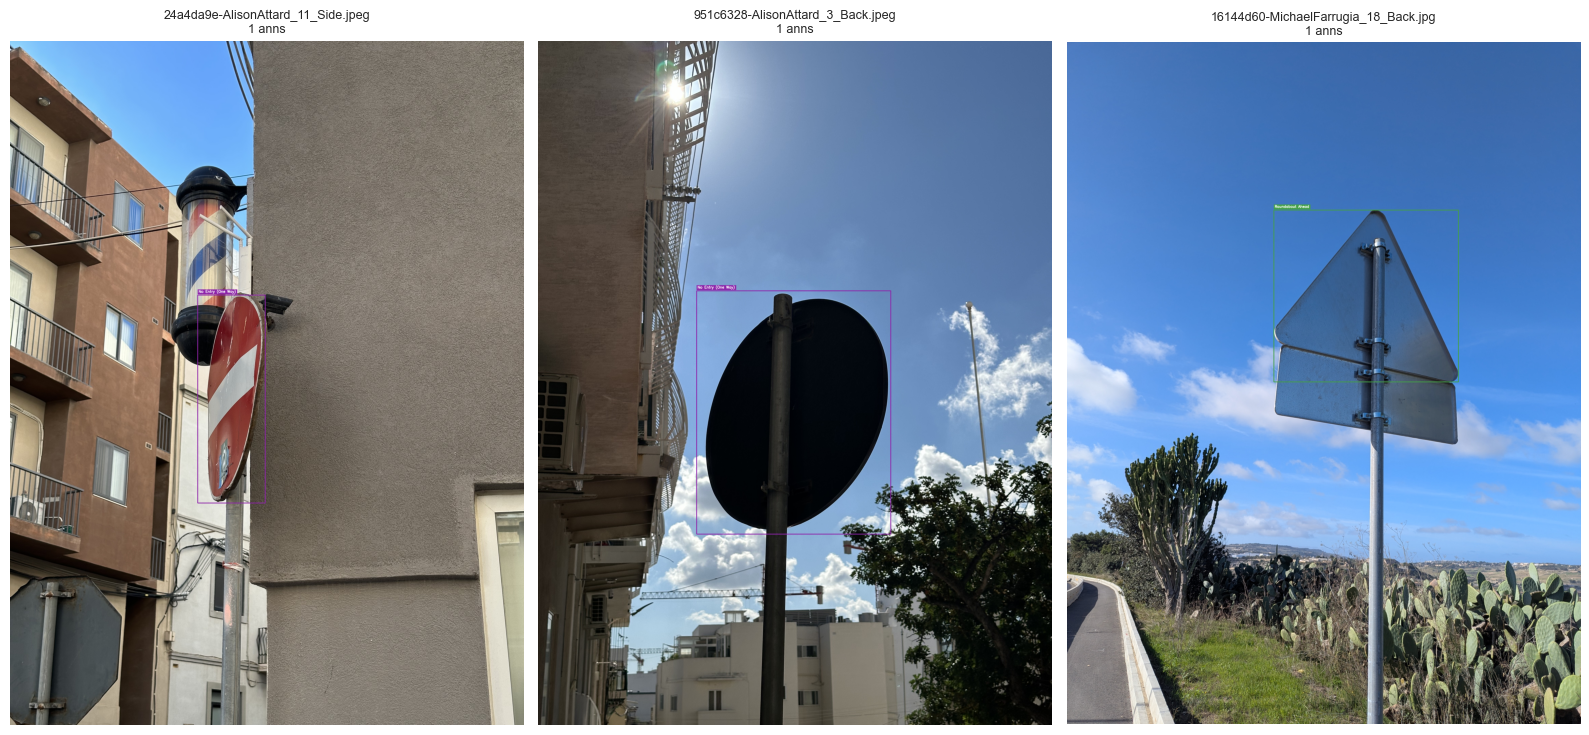

TRANSFORMED SAMPLES (AFTER RESIZE + AUGMENTATION)

Sample 112: 512x512, 1 boxes

Sample 45: 512x512, 1 boxes

Sample 162: 512x512, 1 boxes

 Saved to results/02_transformed.png


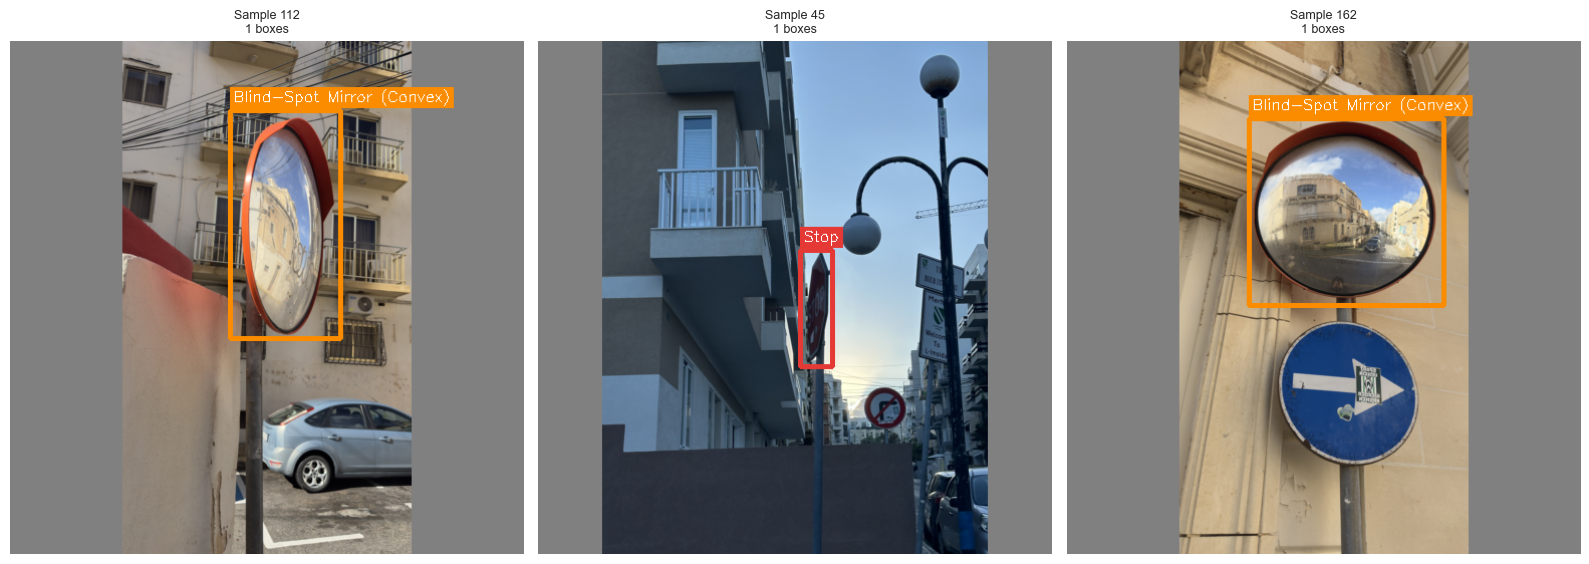

In [ ]:
COLOR_MAP = {
    "Blind-Spot Mirror (Convex)": (0, 140, 251),
    "No Entry (One Way)": (170, 36, 142),
    "No Through Road (T-Sign)": (53, 216, 253),
    "Pedestrian Crossing": (229, 136, 30),
    "Roundabout Ahead": (71, 160, 67),
    "Stop": (53, 57, 229)
}

def visualise_gt_samples(coco_obj, img_dir, class_names, num_samples=2):
    # ground truth samples with bounding boxes
    print(f"GROUND TRUTH SAMPLES (ORIGINAL SIZE)")
    
    img_ids = list(coco_obj.imgs.keys())
    sample_ids = random.sample(img_ids, min(num_samples, len(img_ids)))
    
    fig, axes = plt.subplots(1, len(sample_ids), figsize=(16, 8))
    if len(sample_ids) == 1:
        axes = [axes]
    
    for idx, img_id in enumerate(sample_ids):
        img_info = coco_obj.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, img_info['file_name'])
        
        # PIL with ImageOps.exif_transpose()
        try:
            img_pil = Image.open(img_path).convert("RGB")
            # handles all EXIF orientations
            img_pil = ImageOps.exif_transpose(img_pil)  
            if img_pil is None:
                img_pil = Image.open(img_path).convert("RGB")
            
            img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue
        
        if img is None:
            print(f"Could not read {img_path}")
            continue
        
        ann_ids = coco_obj.getAnnIds(imgIds=img_id)
        anns = coco_obj.loadAnns(ann_ids)
        
        print(f"\n{img_info['file_name']}: {img.shape[1]}x{img.shape[0]}, {len(anns)} annotations")
        
        for ann in anns:
            x, y, w, h = ann['bbox']
            cat_name = coco_obj.cats[ann['category_id']]['name']
            color_bgr = COLOR_MAP.get(cat_name, (255, 255, 255))
            
            cv2.rectangle(img, (int(x), int(y)), (int(x+w), int(y+h)), color_bgr, 4)
            
            label_text = cat_name
            font = cv2.FONT_HERSHEY_SIMPLEX
            (text_width, text_height), baseline = cv2.getTextSize(label_text, font, 0.7, 2)
            y_text_top = max(int(y) - 5, text_height + baseline)
            
            cv2.rectangle(img, (int(x), y_text_top - text_height - baseline - 5),
                         (int(x) + text_width + 10, y_text_top), color_bgr, -1)
            cv2.putText(img, label_text, (int(x) + 5, y_text_top - baseline - 2),
                       font, 0.7, (255, 255, 255), 2)
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f"{img_info['file_name']}\n{len(anns)} anns", fontsize=9)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(str(RESULTS_DIR / "01_gt_original.png"), dpi=150, bbox_inches='tight')
    print("\nSaved to results/01_gt_original.png")
    plt.show()

# visualize training data ground truth
visualise_gt_samples(coco_train_gt, str(TRAIN_IMGS), class_names, num_samples=3)



def visualize_transformed(dataset, num_samples=2):
    """Show what the model actually sees after transforms"""
    
    print(f"TRANSFORMED SAMPLES (AFTER RESIZE + AUGMENTATION)")
   
    
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    fig, axes = plt.subplots(1, len(indices), figsize=(16, 8))
    if len(indices) == 1:
        axes = [axes]
    
    for plot_idx, sample_idx in enumerate(indices):
        image, target = dataset[sample_idx]
        
        # Convert tensor (C,H,W) to numpy (H,W,C) for display
        img_np = image.numpy().transpose(1, 2, 0)
        if img_np.max() <= 1.0:
            img_np = (img_np * 255).astype(np.uint8)
        
        boxes = target['boxes'].numpy() if len(target['boxes']) > 0 else np.array([])
        labels = target['labels'].numpy() if len(target['labels']) > 0 else np.array([])
        
        print(f"\nSample {sample_idx}: {img_np.shape[1]}x{img_np.shape[0]}, {len(boxes)} boxes")
        
        img_display = img_np.copy()
        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box.astype(int)
            cat_name = class_names.get(int(label), f"ID={label}")
            color_bgr = COLOR_MAP.get(cat_name, (255, 255, 255))
            color_bgr_cv = tuple(reversed(color_bgr))
            
            cv2.rectangle(img_display, (x1, y1), (x2, y2), color_bgr_cv, 3)
            
            font = cv2.FONT_HERSHEY_SIMPLEX
            (text_width, text_height), baseline = cv2.getTextSize(cat_name, font, 0.5, 1)
            y_text = max(y1 - 3, text_height + baseline)
            cv2.rectangle(img_display, (x1, y_text - text_height - baseline - 3),
                         (x1 + text_width + 6, y_text), color_bgr_cv, -1)
            cv2.putText(img_display, cat_name, (x1 + 3, y_text - baseline - 1),
                       font, 0.5, (255, 255, 255), 1)
        
        axes[plot_idx].imshow(img_display)
        axes[plot_idx].set_title(f"Sample {sample_idx}\n{len(boxes)} boxes", fontsize=9)
        axes[plot_idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(str(RESULTS_DIR / "02_transformed.png"), dpi=150, bbox_inches='tight')
    print("\n Saved to results/02_transformed.png")
    plt.show()

# RUN: Visualize training data after transformation
visualize_transformed(train_dataset, num_samples=3)

In [ ]:
def validate_dataset(dataset, name):
    # check for invalid boxes, labels, empty images, etc."""
    print(f"VALIDATION: {name}")
    
    invalid = 0
    empty = 0
    box_stats = {'min_w': float('inf'), 'max_w': 0, 'min_h': float('inf'), 'max_h': 0}
    label_dist = {}
    
    for idx in range(len(dataset)):
        image, target = dataset[idx]
        boxes = target['boxes'].numpy() if len(target['boxes']) > 0 else np.array([])
        labels = target['labels'].numpy() if len(target['labels']) > 0 else np.array([])
        
        if len(boxes) == 0:
            empty += 1
            continue
        
        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            
            if x1 >= x2 or y1 >= y2 or w <= 0 or h <= 0:
                print(f"  Invalid box at img {idx}: ({x1}, {y1}, {x2}, {y2})")
                invalid += 1
            
            box_stats['min_w'] = min(box_stats['min_w'], w)
            box_stats['max_w'] = max(box_stats['max_w'], w)
            box_stats['min_h'] = min(box_stats['min_h'], h)
            box_stats['max_h'] = max(box_stats['max_h'], h)
            
            label_id = int(label)
            label_dist[label_id] = label_dist.get(label_id, 0) + 1
            
            if label_id < 1 or label_id > 6:
                print(f"  Invalid label {label_id} at img {idx}")
                invalid += 1
    
    print(f"\nImages: {len(dataset)} | Empty: {empty} | Invalid: {invalid}")
    print(f"Box sizes (W×H): {box_stats['min_w']:.1f}-{box_stats['max_w']:.1f} × {box_stats['min_h']:.1f}-{box_stats['max_h']:.1f} px")
    print(f"\nLabel distribution:")
    for lid in sorted(label_dist.keys()):
        cname = class_names.get(lid, "?")
        print(f"  Class {lid} ({cname}): {label_dist[lid]} boxes")
    
    if invalid == 0:
        print(f"\n no issues found")
    else:
        print(f"\n{invalid} invalid items")

validate_dataset(train_dataset, "Training")
validate_dataset(val_dataset, "Validation")
validate_dataset(test_dataset, "Test")


print("SANITY CHECKS COMPLETE")


VALIDATION: Training

Images: 483 | Empty: 0 | Invalid: 0
Box sizes (W×H): 8.0-290.5 × 11.1-311.6 px

Label distribution:
  Class 1 (Blind-Spot Mirror (Convex)): 71 boxes
  Class 2 (No Entry (One Way)): 209 boxes
  Class 3 (No Through Road (T-Sign)): 47 boxes
  Class 4 (Pedestrian Crossing): 62 boxes
  Class 5 (Roundabout Ahead): 24 boxes
  Class 6 (Stop): 114 boxes

 no issues found
VALIDATION: Validation

Images: 88 | Empty: 0 | Invalid: 0
Box sizes (W×H): 12.9-211.8 × 18.0-257.3 px

Label distribution:
  Class 1 (Blind-Spot Mirror (Convex)): 15 boxes
  Class 2 (No Entry (One Way)): 33 boxes
  Class 3 (No Through Road (T-Sign)): 14 boxes
  Class 4 (Pedestrian Crossing): 9 boxes
  Class 5 (Roundabout Ahead): 5 boxes
  Class 6 (Stop): 16 boxes

 no issues found
VALIDATION: Test

Images: 86 | Empty: 0 | Invalid: 0
Box sizes (W×H): 13.6-361.1 × 20.0-241.2 px

Label distribution:
  Class 1 (Blind-Spot Mirror (Convex)): 17 boxes
  Class 2 (No Entry (One Way)): 37 boxes
  Class 3 (No Throug

## Section 4: Training

In [140]:
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler() if device.type == 'cuda' else None

class Timer:
    def __init__(self):
        self.start_time = None
        self.elapsed = 0.0
    
    def start(self):
        self.start_time = time.time()
    
    def stop(self):
        if self.start_time is not None:
            self.elapsed += time.time() - self.start_time
            self.start_time = None
    
    def get_elapsed_hours(self):
        return self.elapsed / 3600.0
    
    def get_elapsed_minutes(self):
        return self.elapsed / 60.0
    
    def reset(self):
        self.start_time = None
        self.elapsed = 0.0

total_timer = Timer()
epoch_timer = Timer()

print("starting training")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

total_timer.start()
epoch_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_timer.start()
    print("epoch {}/{}".format(epoch, NUM_EPOCHS))
    
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    for batch_idx, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v 
                   for k, v in t.items()} for t in targets]
        
        if device.type == 'cuda':  # mixed precision only on GPU
            with autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            scaler.scale(losses).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:  # training on CPU
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        
        total_loss += losses.item()
        num_batches += 1
        
        # printing every 15 batches
        if (batch_idx + 1) % 15 == 0 or (batch_idx + 1) == len(train_loader):
            print("epoch {}/{} batch {}/{}: loss={:.4f}".format(epoch, NUM_EPOCHS, batch_idx + 1, len(train_loader), losses.item()))
    
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
    epoch_losses.append(avg_loss)
    
    epoch_timer.stop()
    epoch_time = epoch_timer.elapsed / 60.0
    epoch_timer.reset()
    
    print("epoch {} - loss: {:.4f} - time: {:.2f} min".format(epoch, avg_loss, epoch_time))
    
    writer.add_scalar("Loss/train", avg_loss, epoch)
    lr_scheduler.step()
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

total_timer.stop()
total_training_time_hours = total_timer.get_elapsed_hours()

print("\ntraining complete")
print("total time: {:.2f} hours ({:.2f} minutes)".format(
    total_training_time_hours, total_timer.get_elapsed_minutes()))

checkpoint = {
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}

torch.save(checkpoint, CHECKPOINT_DIR / "checkpoint_final.pth")
print("checkpoint saved: {}".format(CHECKPOINT_DIR / "checkpoint_final.pth"))

writer.close()

starting training
epoch 1/8
epoch 1/8 batch 15/61: loss=0.4910
epoch 1/8 batch 30/61: loss=0.5075
epoch 1/8 batch 45/61: loss=0.4281
epoch 1/8 batch 60/61: loss=0.4136
epoch 1/8 batch 61/61: loss=0.5429
epoch 1 - loss: 0.5219 - time: 8.39 min
epoch 2/8
epoch 2/8 batch 15/61: loss=0.4314
epoch 2/8 batch 30/61: loss=0.4007
epoch 2/8 batch 45/61: loss=0.4194
epoch 2/8 batch 60/61: loss=0.3982
epoch 2/8 batch 61/61: loss=0.3658
epoch 2 - loss: 0.4462 - time: 7.92 min
epoch 3/8
epoch 3/8 batch 15/61: loss=0.4099
epoch 3/8 batch 30/61: loss=0.4607
epoch 3/8 batch 45/61: loss=0.3437
epoch 3/8 batch 60/61: loss=0.3640
epoch 3/8 batch 61/61: loss=0.3301
epoch 3 - loss: 0.3944 - time: 8.18 min
epoch 4/8
epoch 4/8 batch 15/61: loss=0.3128
epoch 4/8 batch 30/61: loss=0.5265
epoch 4/8 batch 45/61: loss=0.3187
epoch 4/8 batch 60/61: loss=0.2900
epoch 4/8 batch 61/61: loss=0.3749
epoch 4 - loss: 0.3669 - time: 8.02 min
epoch 5/8
epoch 5/8 batch 15/61: loss=0.3296
epoch 5/8 batch 30/61: loss=0.9140
ep

## Section 5: Test Set Evaluation (COCO Metrics)


In [ ]:

checkpoint_path = CHECKPOINT_DIR / "checkpoint_final.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print("model loaded from: {}".format(checkpoint_path))

model.eval()
test_results = []

with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        for output, target in zip(outputs, targets):
            image_id = target["image_id"].item()
            boxes = output["boxes"].cpu().numpy()
            scores = output["scores"].cpu().numpy()
            labels = output["labels"].cpu().numpy()
            
            for box, score, label in zip(boxes, scores, labels):
                result = {
                    "image_id": image_id,
                    "category_id": int(label),
                    "bbox": [box[0], box[1], box[2] - box[0], box[3] - box[1]],
                    "score": float(score),
                }
                test_results.append(result)

if len(test_results) > 0:
    coco_dt = coco_test_gt.loadRes(test_results)
    coco_eval = COCOeval(coco_test_gt, coco_dt, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    mAP = coco_eval.stats[0]
    AP50 = coco_eval.stats[1]
    AP75 = coco_eval.stats[2]
    
    metrics_table = pd.DataFrame({
        "metric": ["mAP (0.50:0.95)", "AP50", "AP75"],
        "value": [mAP, AP50, AP75]
    })
    
    print("\noverall metrics")
    print(metrics_table.to_string(index=False))
    
    metrics_csv_path = RESULTS_DIR / "test_metrics.csv"
    metrics_table.to_csv(metrics_csv_path, index=False)
    print("metrics saved to: {}".format(metrics_csv_path))
else:
    print("no results generated")
    mAP = 0.0
    AP50 = 0.0
    AP75 = 0.0


model loaded from: /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/maskrcnn_resnet50_fpn_sign_type/checkpoints/checkpoint_final.pth
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=

In [ ]:
# checking metrics computation

checkpoint_path = CHECKPOINT_DIR / "checkpoint_final.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Model loaded from: {checkpoint_path}")

model.eval()
test_results = []
total_predictions = 0

with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(test_loader):
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        print(f"\nBatch {batch_idx + 1}:")
        print(f"  Images in batch: {len(images)}")
        print(f"  Predictions returned: {len(outputs)}")
        
        for img_idx, (output, target) in enumerate(zip(outputs, targets)):
            image_id = target["image_id"].item()
            boxes = output["boxes"]
            scores = output["scores"]
            labels = output["labels"]
            
            print(f"    Image {image_id}: {len(boxes)} detections")
            
            # keep high-confidence predictions
            confidence_threshold = 0.3
            high_conf = scores >= confidence_threshold
            
            if high_conf.sum() > 0:
                filtered_boxes = boxes[high_conf].cpu().numpy()
                filtered_scores = scores[high_conf].cpu().numpy()
                filtered_labels = labels[high_conf].cpu().numpy()
                
                print(f"      High-conf (>{confidence_threshold}): {len(filtered_boxes)} detections")
                
                for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
                    result = {
                        "image_id": int(image_id),
                        "category_id": int(label),
                        "bbox": [float(box[0]), float(box[1]), float(box[2] - box[0]), float(box[3] - box[1])],
                        "score": float(score),
                    }
                    test_results.append(result)
                    total_predictions += 1

print(f"SUMMARY:")
print(f"  Total images in test set: {len(test_dataset)}")
print(f"  Total predictions: {total_predictions}")


# compute metrics
if len(test_results) > 0:
    print(f"\n Computing metrics from {len(test_results)} predictions")
    
    try:
        coco_dt = coco_test_gt.loadRes(test_results)
        coco_eval = COCOeval(coco_test_gt, coco_dt, "bbox")
        
        print("  Running COCO evaluation...")
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        
        # metrics
        mAP = coco_eval.stats[0]
        AP50 = coco_eval.stats[1]
        AP75 = coco_eval.stats[2]
        AR = coco_eval.stats[8] 
        
        print("TEST SET METRICS")
        print(f"mAP (0.50:0.95): {mAP:.4f}")
        print(f"AP50 (IoU=0.50):  {AP50:.4f}")
        print(f"AP75 (IoU=0.75):  {AP75:.4f}")
        print(f"Average Recall:   {AR:.4f}")
        
        # save metrics
        metrics_table = pd.DataFrame({
            "metric": ["mAP (0.50:0.95)", "AP50", "AP75", "Average Recall"],
            "value": [mAP, AP50, AP75, AR]
        })
        print("\nMetrics Table:")
        print(metrics_table.to_string(index=False))
        
        metrics_csv_path = RESULTS_DIR / "test_metrics.csv"
        metrics_table.to_csv(metrics_csv_path, index=False)
        print(f"\n Metrics saved to: {metrics_csv_path}")
        
    except Exception as e:
        print(f" Error during evaluation: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"\  No results generated. Total predictions: {total_predictions}")
    print("   This means the model is not making any detections.")
    print("   Possible causes:")
    print("   - Model not properly trained")
    print("   - Confidence threshold too high")
    print("   - Model weights not loaded correctly")

Model loaded from: /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/maskrcnn_resnet50_fpn_sign_type/checkpoints/checkpoint_final.pth


<>:98: SyntaxWarning: invalid escape sequence '\ '
<>:98: SyntaxWarning: invalid escape sequence '\ '
/var/folders/0c/hjszxlb13jb8vnn82fy3y__40000gn/T/ipykernel_23285/220955952.py:98: SyntaxWarning: invalid escape sequence '\ '
  print(f"\  No results generated! Total predictions: {total_predictions}")



Batch 1:
  Images in batch: 8
  Predictions returned: 8
    Image 8: 11 detections
      High-conf (>0.3): 1 detections
    Image 10: 14 detections
      High-conf (>0.3): 1 detections
    Image 21: 19 detections
      High-conf (>0.3): 2 detections
    Image 27: 14 detections
      High-conf (>0.3): 3 detections
    Image 31: 16 detections
      High-conf (>0.3): 1 detections
    Image 35: 18 detections
      High-conf (>0.3): 2 detections
    Image 40: 8 detections
      High-conf (>0.3): 1 detections
    Image 53: 20 detections
      High-conf (>0.3): 2 detections

Batch 2:
  Images in batch: 8
  Predictions returned: 8
    Image 62: 17 detections
      High-conf (>0.3): 3 detections
    Image 66: 20 detections
      High-conf (>0.3): 1 detections
    Image 72: 22 detections
      High-conf (>0.3): 1 detections
    Image 84: 13 detections
      High-conf (>0.3): 2 detections
    Image 85: 21 detections
      High-conf (>0.3): 1 detections
    Image 88: 22 detections
      High-conf

In [ ]:

import json

checkpoint_path = CHECKPOINT_DIR / "checkpoint_final.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("PREDICTION ANALYSIS")

# analyze ONE test image in detail
test_image_idx = 0 
image, target = test_dataset[test_image_idx]

# Get ground truth
print(f"\nGround Truth for Sample {test_image_idx}:")
print(f"  Image ID: {target['image_id'].item()}")
print(f"  Ground truth boxes: {len(target['boxes'])}")
for idx, (box, label) in enumerate(zip(target['boxes'], target['labels'])):
    x1, y1, x2, y2 = box.tolist()
    w = x2 - x1
    h = y2 - y1
    print(f"    Box {idx}: [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}] (w={w:.1f}, h={h:.1f}) - Class {label.item()}")

# model predictions
with torch.no_grad():
    image_tensor = image.to(device) 
    output = model([image_tensor])[0] 

print(f"\nModel Predictions:")
print(f"  Total predictions: {len(output['boxes'])}")

# sort by confidence
sorted_indices = torch.argsort(output['scores'], descending=True)

print(f"\n  Top 10 predictions (sorted by confidence):")
for i, idx in enumerate(sorted_indices[:10]):
    box = output['boxes'][idx].cpu().numpy()
    score = output['scores'][idx].item()
    label = output['labels'][idx].item()
    
    x1, y1, x2, y2 = box
    w = x2 - x1
    h = y2 - y1
    
    print(f"    Pred {i}: Class {label}, Score {score:.4f}, Box [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}] (w={w:.1f}, h={h:.1f})")

# check score distribution
scores = output['scores'].cpu().numpy()
print(f"\nScore Distribution:")
print(f"  Min score:  {scores.min():.4f}")
print(f"  Max score:  {scores.max():.4f}")
print(f"  Mean score: {scores.mean():.4f}")
print(f"  Median score: {np.median(scores):.4f}")
print(f"  Scores > 0.5: {(scores > 0.5).sum()}")
print(f"  Scores > 0.3: {(scores > 0.3).sum()}")
print(f"  Scores > 0.1: {(scores > 0.1).sum()}")

# check category distribution
labels = output['labels'].cpu().numpy()
print(f"\nPredicted Categories:")
for cat_id in sorted(np.unique(labels)):
    count = (labels == cat_id).sum()
    cat_name = class_names.get(cat_id, f"Unknown")
    print(f"  Class {cat_id} ({cat_name}): {count} predictions")

print(f"\nExpected Categories (from ground truth):")
for cat_id in sorted(np.unique(target['labels'].numpy())):
    cat_name = class_names.get(cat_id, f"Unknown")
    print(f"  Class {cat_id} ({cat_name}): Expected")

# check coordinates
print("COORDINATE SYSTEM CHECK")

print(f"\nImage shape: {image.shape}")
print(f"Expected box coordinates range: [0, {image.shape[2]}] x [0, {image.shape[1]}]")

# check if any predictions are out of bounds
pred_boxes = output['boxes'].cpu().numpy()
print(f"\nPredicted box coordinate ranges:")
print(f"  X1 (left):   [{pred_boxes[:, 0].min():.1f}, {pred_boxes[:, 0].max():.1f}]")
print(f"  Y1 (top):    [{pred_boxes[:, 1].min():.1f}, {pred_boxes[:, 1].max():.1f}]")
print(f"  X2 (right):  [{pred_boxes[:, 2].min():.1f}, {pred_boxes[:, 2].max():.1f}]")
print(f"  Y2 (bottom): [{pred_boxes[:, 3].min():.1f}, {pred_boxes[:, 3].max():.1f}]")

# check if boxes are within image bounds
valid_boxes = (
    (pred_boxes[:, 0] >= 0) & (pred_boxes[:, 2] <= image.shape[2]) &
    (pred_boxes[:, 1] >= 0) & (pred_boxes[:, 3] <= image.shape[1])
)
print(f"\nBoxes within image bounds: {valid_boxes.sum()}/{len(pred_boxes)}")

# sample prediction visualisation
print("Sample Predictions (first 5)")

for pred_idx in range(min(5, len(output['boxes']))):
    box = output['boxes'][pred_idx].cpu().numpy()
    score = output['scores'][pred_idx].item()
    label = output['labels'][pred_idx].item()
    
    x1, y1, x2, y2 = box
    w = x2 - x1
    h = y2 - y1
    area = w * h
    
    print(f"\nPrediction {pred_idx}:")
    print(f"  Class: {label}")
    print(f"  Confidence: {score:.4f}")
    print(f"  Box: x1={x1:.1f}, y1={y1:.1f}, x2={x2:.1f}, y2={y2:.1f}")
    print(f"  Size: {w:.1f} x {h:.1f} = {area:.0f} pixels")
    print(f"  Valid coords? {valid_boxes[pred_idx]}")


PREDICTION ANALYSIS

Ground Truth for Sample 0:
  Image ID: 8
  Ground truth boxes: 1
    Box 0: [228.3, 189.9, 321.2, 294.9] (w=92.9, h=105.0) - Class 2

Model Predictions:
  Total predictions: 11

  Top 10 predictions (sorted by confidence):
    Pred 0: Class 2, Score 0.6676, Box [228.4, 188.9, 311.8, 285.6] (w=83.4, h=96.7)
    Pred 1: Class 6, Score 0.2560, Box [213.4, 171.3, 328.5, 299.9] (w=115.2, h=128.6)
    Pred 2: Class 2, Score 0.1972, Box [220.6, 143.0, 318.6, 315.4] (w=98.0, h=172.4)
    Pred 3: Class 2, Score 0.1887, Box [192.1, 175.7, 341.2, 291.4] (w=149.1, h=115.7)
    Pred 4: Class 1, Score 0.1605, Box [205.2, 186.6, 299.1, 297.1] (w=93.8, h=110.4)
    Pred 5: Class 6, Score 0.1410, Box [266.6, 8.9, 447.6, 186.9] (w=181.0, h=178.1)
    Pred 6: Class 1, Score 0.1237, Box [224.7, 161.4, 316.9, 339.3] (w=92.2, h=178.0)
    Pred 7: Class 1, Score 0.0978, Box [217.0, 220.9, 319.0, 292.6] (w=102.0, h=71.8)
    Pred 8: Class 1, Score 0.0685, Box [183.6, 178.1, 376.7, 291.1] 

## Section 6: Training Curves and Monitoring

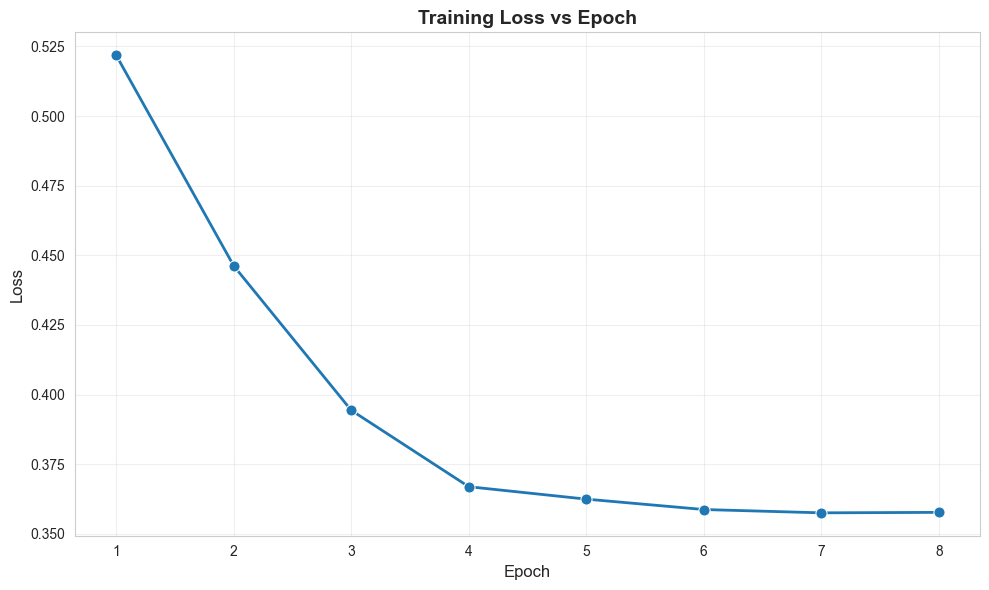

training curves saved


In [144]:
# training curves and monitoring

history_df = pd.DataFrame({
    "epoch": list(range(1, NUM_EPOCHS + 1)),
    "loss": epoch_losses
})

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=history_df, x="epoch", y="loss", marker="o", ax=ax, linewidth=2, markersize=8)
ax.set_title("Training Loss vs Epoch", fontsize=14, fontweight='bold')
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(str(RESULTS_DIR / "training_curves.png"), dpi=150, bbox_inches='tight')
plt.show()

print("training curves saved")



## Section 7: Qualitative Results and Failure Analysis

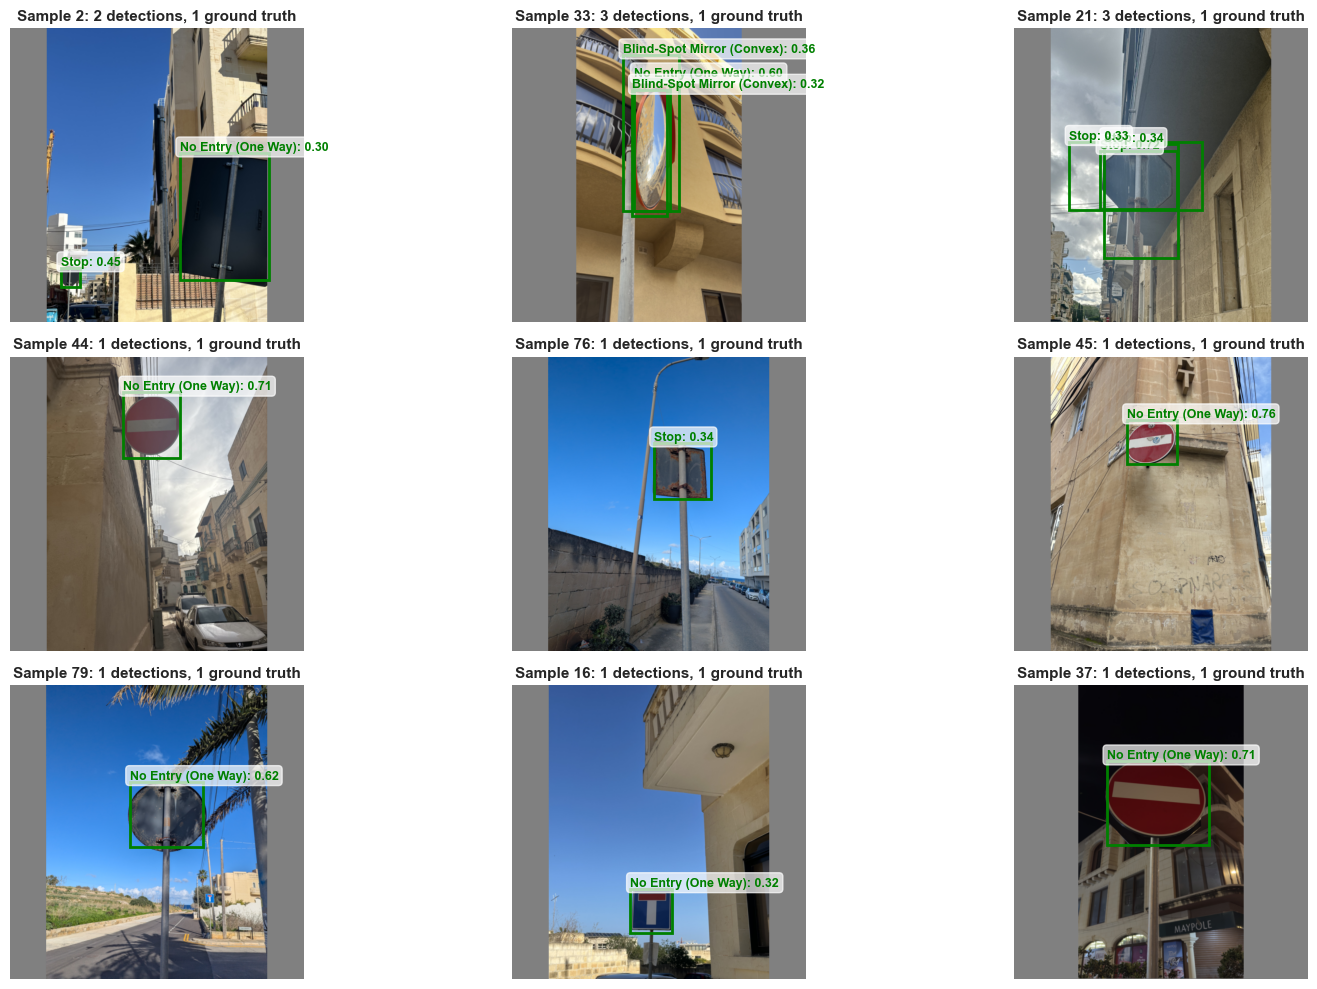

qualitative results visualization saved


In [156]:


def visualise_predictions(model, dataset, num_samples=9, device="cpu", threshold=0.3):
    model.eval()
    
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    fig, axes = plt.subplots(3, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    with torch.no_grad():
        for idx, sample_idx in enumerate(indices):
            image, target = dataset[sample_idx]
            image_tensor = image.to(device) 
            
            predictions = model([image_tensor]) 
            
            image_np = image.cpu().permute(1, 2, 0).numpy()
            image_np = (image_np * 255).astype(np.uint8)
            
            ax = axes[idx]
            ax.imshow(image_np)
            
            pred = predictions[0]
            boxes = pred["boxes"].cpu().numpy()
            scores = pred["scores"].cpu().numpy()
            labels = pred["labels"].cpu().numpy()
            
            correct_count = 0
            
            for box, score, label in zip(boxes, scores, labels):
                if score > threshold:
                    x1, y1, x2, y2 = box
                    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                            linewidth=2, edgecolor='green', facecolor='none')
                    ax.add_patch(rect)
                    class_name = class_names.get(int(label), "unknown")
                    ax.text(x1, y1-5, "{}: {:.2f}".format(class_name, score), 
                           color='green', fontsize=9, fontweight='bold',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                    correct_count += 1
            
            num_gt = len(target['boxes'])
            ax.set_title("Sample {}: {} detections, {} ground truth".format(
                sample_idx, correct_count, num_gt), fontsize=11, fontweight='bold')
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(str(RESULTS_DIR / "qualitative_results.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    print("qualitative results visualization saved")

visualise_predictions(model, test_dataset, num_samples=9, device=device, threshold=CONFIDENCE_THRESHOLD)

## Failure analysis

**Common challenges observed:**
- **Small signs:** difficult to detect after resizing to **224×224**. While this reduced training time, using **512×512** images produced the best performance.
- **Underrepresented signs:** the model struggled most with **classes that appeared less frequently** in the training set, leading to missed detections or incorrect classifications.
- **Occluded signs:** partially hidden signs tended to produce **lower confidence scores** and incomplete detections.
- **Reflections:** shiny or reflective sign surfaces caused **detection inconsistencies** due to glare and highlights.
- **Distance:** signs far from the camera had **low pixel density**, making features harder to learn and recognise.
- **Unusual angles:** signs captured at non-frontal viewpoints (tilted/rotated) were **harder to detect reliably**.


## Section 8: Per-Image Analytics

In [ ]:

def analyze_detections(model, dataset, num_images=10, threshold=0.5, device="cpu"):
    model.eval()
    
    np.random.seed(SEED)
    indices = np.random.choice(len(dataset), min(num_images, len(dataset)), replace=False)
    
    analytics = []
    
    with torch.no_grad():
        for image_idx in indices:
            image, target = dataset[image_idx]
            image_tensor = image.to(device)
            
            predictions = model([image_tensor])
            pred = predictions[0]
            
            boxes = pred["boxes"].cpu().numpy()
            scores = pred["scores"].cpu().numpy()
            labels = pred["labels"].cpu().numpy()
            
            mask = scores > threshold
            scores = scores[mask]
            labels = labels[mask]
            
            total_detections = len(scores)
            mean_confidence = scores.mean() if len(scores) > 0 else 0.0
            
            class_counts = {}
            for label in labels:
                class_name = class_names.get(int(label), "unknown")
                class_counts[class_name] = class_counts.get(class_name, 0) + 1
            
            gt_count = len(target['boxes'])
            
            analytics.append({
                "image_id": image_idx,
                "detections": total_detections,
                "ground_truth": gt_count,
                "mean_confidence": mean_confidence,
                "class_breakdown": str(class_counts)
            })
    
    analytics_df = pd.DataFrame(analytics)
    
    print("\nper-image detection analytics")
    print(analytics_df.to_string(index=False))
    
    analytics_csv_path = RESULTS_DIR / "per_image_analytics.csv"
    analytics_df.to_csv(analytics_csv_path, index=False)
    print("per-image analytics saved to: {}".format(analytics_csv_path))
    
    return analytics_df


if not SKIP_VISUALIZATIONS:
    analytics_df = analyze_detections(model, test_dataset, num_images=10, threshold=CONFIDENCE_THRESHOLD, device=device)
else:
    print("skipping per-image analytics (speed testing mode)")
    analytics_df = None


per-image detection analytics
 image_id  detections  ground_truth  mean_confidence                                            class_breakdown
       70           2             1         0.596011                                                {'Stop': 2}
       28           1             1         0.831234                                  {'No Entry (One Way)': 1}
       67           0             1         0.000000                                                         {}
       80           0             1         0.000000                                                         {}
       29           2             1         0.495104 {'No Entry (One Way)': 1, 'Blind-Spot Mirror (Convex)': 1}
       57           1             1         0.415705                                  {'No Entry (One Way)': 1}
       23           2             1         0.387806 {'No Entry (One Way)': 1, 'Blind-Spot Mirror (Convex)': 1}
       39           1             1         0.441937                     

Analytics visualization saved to: /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/maskrcnn_resnet50_fpn_sign_type/results/analytics_visualization.png


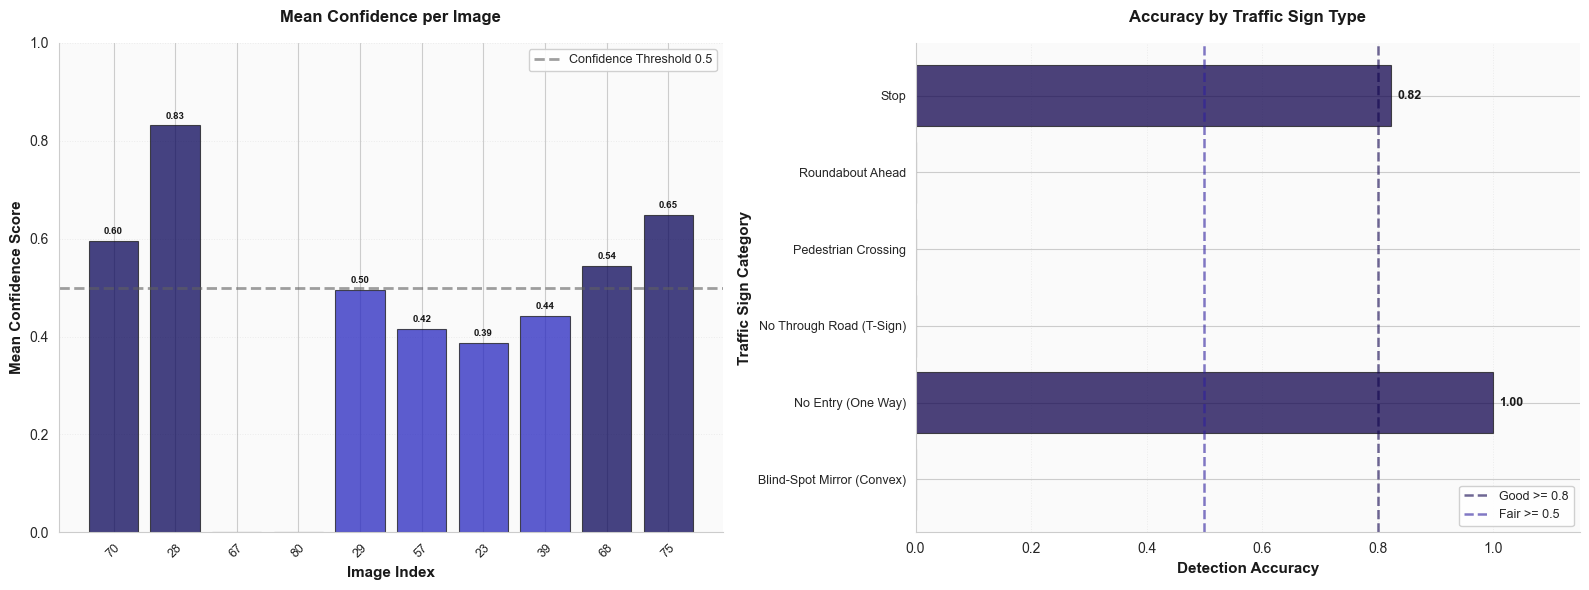


OVERALL SUMMARY STATISTICS

Total Predictions:           12 detections
Total Ground Truth:          10 boxes
Average Accuracy Ratio:      80.00%
Average Confidence Score:    0.4359

Images with exact count:     4 out of 10
Images with any detection:   8 out of 10
Images above confidence 0.5: 4 out of 10

Good Performance >=80:       8 images
Fair Performance 50-80:      0 images
Poor Performance <50:        2 images

ACCURACY BY SIGN TYPE

Blind-Spot Mirror (Convex)         :  0 out of 17 detected (  0.0%)
No Entry (One Way)                 : 45 out of 37 detected (100.0%)
No Through Road (T-Sign)           :  0 out of 10 detected (  0.0%)
Pedestrian Crossing                :  0 out of  9 detected (  0.0%)
Roundabout Ahead                   :  0 out of  3 detected (  0.0%)
Stop                               : 14 out of 17 detected ( 82.4%)



In [170]:
def visualize_analytics(model, test_dataset, analytics_df, results_dir, device="cpu"):
    
    
    fig = plt.figure(figsize=(16, 6))
    fig.patch.set_facecolor('white')
    
    ax1 = plt.subplot(1, 2, 1)
    
    colors = ["#080458" if conf > 0.5 else "#2727C0" for conf in analytics_df['mean_confidence']]
    bars = ax1.bar(range(len(analytics_df)), analytics_df['mean_confidence'], color=colors, alpha=0.75, edgecolor='#1a1a1a', linewidth=0.8)
    
    ax1.axhline(y=0.5, color='#606060', linestyle='--', linewidth=2, label='Confidence Threshold 0.5', alpha=0.6)
    ax1.set_xlabel('Image Index', fontsize=11, fontweight='bold', color='#1a1a1a')
    ax1.set_ylabel('Mean Confidence Score', fontsize=11, fontweight='bold', color='#1a1a1a')
    ax1.set_title('Mean Confidence per Image', fontsize=12, fontweight='bold', color='#1a1a1a', pad=15)
    ax1.set_xticks(range(len(analytics_df)))
    ax1.set_xticklabels(analytics_df['image_id'], rotation=45, fontsize=9)
    ax1.set_ylim([0, 1])
    ax1.legend(fontsize=9, framealpha=0.9, edgecolor='#cccccc')
    ax1.grid(axis='y', alpha=0.15, linewidth=0.7, linestyle=':', color='#999999')
    ax1.set_facecolor('#fafafa')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_color('#cccccc')
    ax1.spines['bottom'].set_color('#cccccc')
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=7, fontweight='bold', color='#1a1a1a')
    
    ax2 = plt.subplot(1, 2, 2)
    
    category_stats = {}
    model.eval()
    
    with torch.no_grad():
        for image_idx in range(len(test_dataset)):
            image, target = test_dataset[image_idx]
            image_tensor = image.to(device)
            predictions = model([image_tensor])
            pred = predictions[0]
            
            gt_labels = target['labels'].numpy()
            pred_labels = pred['labels'].cpu().numpy()
            pred_scores = pred['scores'].cpu().numpy()
            
            for gt_label in gt_labels:
                cat_name = class_names.get(int(gt_label), "unknown")
                if cat_name not in category_stats:
                    category_stats[cat_name] = {'gt': 0, 'detected': 0}
                category_stats[cat_name]['gt'] += 1
            
            mask = pred_scores > 0.5
            for pred_label in pred_labels[mask]:
                cat_name = class_names.get(int(pred_label), "unknown")
                if cat_name not in category_stats:
                    category_stats[cat_name] = {'gt': 0, 'detected': 0}
                category_stats[cat_name]['detected'] += 1
    
    categories = sorted(list(category_stats.keys()))
    accuracy_by_category = []
    
    for cat in categories:
        if category_stats[cat]['gt'] > 0:
            acc = min(category_stats[cat]['detected'] / category_stats[cat]['gt'], 1.0)
        else:
            acc = 0.0
        accuracy_by_category.append(acc)
    
    colors_cat = ['#10034E' if acc >= 0.8 else "#272C52" if acc >= 0.5 else '#909090' for acc in accuracy_by_category]
    bars = ax2.barh(range(len(categories)), accuracy_by_category, color=colors_cat, alpha=0.75, edgecolor='#1a1a1a', linewidth=0.8)
    
    ax2.axvline(x=0.8, color="#10034E", linestyle='--', linewidth=1.8, alpha=0.6, label='Good >= 0.8')
    ax2.axvline(x=0.5, color="#2E1F9E", linestyle='--', linewidth=1.8, alpha=0.6, label='Fair >= 0.5')
    ax2.set_ylabel('Traffic Sign Category', fontsize=11, fontweight='bold', color='#1a1a1a')
    ax2.set_xlabel('Detection Accuracy', fontsize=11, fontweight='bold', color='#1a1a1a')
    ax2.set_title('Accuracy by Traffic Sign Type', fontsize=12, fontweight='bold', color='#1a1a1a', pad=15)
    ax2.set_yticks(range(len(categories)))
    ax2.set_yticklabels(categories, fontsize=9)
    ax2.set_xlim([0, 1.15])
    ax2.legend(fontsize=9, loc='lower right', framealpha=0.9, edgecolor='#cccccc')
    ax2.grid(axis='x', alpha=0.15, linewidth=0.7, linestyle=':', color='#999999')
    ax2.set_facecolor('#fafafa')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_color('#cccccc')
    ax2.spines['bottom'].set_color('#cccccc')
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        if width > 0:
            ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
                    f'{width:.2f}',
                    ha='left', va='center', fontsize=9, fontweight='bold', color='#1a1a1a')
    
    plt.tight_layout()
    plt.savefig(str(results_dir / "analytics_visualization.png"), dpi=150, bbox_inches='tight', facecolor='white')
    print("Analytics visualization saved to: {}/analytics_visualization.png".format(results_dir))
    plt.show()
    
    accuracy = []
    for idx, row in analytics_df.iterrows():
        if row['ground_truth'] > 0:
            acc = min(row['detections'] / row['ground_truth'], 1.0)
        else:
            acc = 0.0
        accuracy.append(acc)
    
    analytics_df['accuracy'] = accuracy
    
    total_detections = analytics_df['detections'].sum()
    total_gt = analytics_df['ground_truth'].sum()
    avg_confidence = analytics_df['mean_confidence'].mean()
    avg_accuracy = np.mean(accuracy)
    
    images_with_correct_detections = (analytics_df['detections'] == analytics_df['ground_truth']).sum()
    images_with_any_detection = (analytics_df['detections'] > 0).sum()
    images_with_confidence_above_threshold = (analytics_df['mean_confidence'] >= 0.5).sum()
    
    summary_text = f"""
OVERALL SUMMARY STATISTICS

Total Predictions:           {total_detections} detections
Total Ground Truth:          {total_gt} boxes
Average Accuracy Ratio:      {avg_accuracy:.2%}
Average Confidence Score:    {avg_confidence:.4f}

Images with exact count:     {images_with_correct_detections} out of {len(analytics_df)}
Images with any detection:   {images_with_any_detection} out of {len(analytics_df)}
Images above confidence 0.5: {images_with_confidence_above_threshold} out of {len(analytics_df)}

Good Performance >=80:       {sum(1 for a in accuracy if a >= 0.8)} images
Fair Performance 50-80:      {sum(1 for a in accuracy if 0.5 <= a < 0.8)} images
Poor Performance <50:        {sum(1 for a in accuracy if a < 0.5)} images

ACCURACY BY SIGN TYPE

"""
    
    for cat in categories:
        detected = category_stats[cat]['detected']
        total = category_stats[cat]['gt']
        if total > 0:
            acc = min(detected / total, 1.0)
        else:
            acc = 0.0
        summary_text += f"{cat:35s}: {detected:2d} out of {total:2d} detected ({acc:6.1%})\n"
    
    print(summary_text)
    
    return analytics_df

if analytics_df is not None:
    analytics_df = visualize_analytics(model, test_dataset, analytics_df, RESULTS_DIR, device=device)
else:
    print("No analytics data to visualise")


## Section 9: Inference Speed Measurement

In [151]:

def measure_speed(model, loader, num_warmup=10, num_timed=100, device="cpu"):
    model.eval()
    
    times = []
    batch_count = 0
    
    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            
            if batch_count < num_warmup:
                _ = model(images)
                batch_count += 1
                continue
            
            if batch_count < num_warmup + num_timed:
                start_time = time.time()
                _ = model(images)
                elapsed = time.time() - start_time
                times.append(elapsed)
                batch_count += 1
            else:
                break
    
    if len(times) > 0:
        times = np.array(times) * 1000
        mean_latency = times.mean()
        std_latency = times.std()
        fps = 1000.0 / mean_latency
        
        speed_table = pd.DataFrame({
            "metric": ["mean latency (ms)", "std latency (ms)", "fps"],
            "value": [mean_latency, std_latency, fps]
        })
        
        print("\ninference speed (batch_size={}, {} test images)".format(BATCH_SIZE, len(times)))
        print(speed_table.to_string(index=False))
        
        speed_csv_path = RESULTS_DIR / "inference_speed.csv"
        speed_table.to_csv(speed_csv_path, index=False)
        print("inference speed saved to: {}".format(speed_csv_path))
        
        return mean_latency, std_latency, fps
    
    return 0.0, 0.0, 0.0

mean_latency, std_latency, fps = measure_speed(model, test_loader, num_warmup=10, num_timed=100, device=device)



inference speed (batch_size=8, 1 test images)
           metric       value
mean latency (ms) 2482.480288
 std latency (ms)    0.000000
              fps    0.402823
inference speed saved to: /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/maskrcnn_resnet50_fpn_sign_type/results/inference_speed.csv


## Section 10: Results Export for 2c Comparison


In [152]:

results_export = {
    "detector_name": DETECTOR_NAME,
    "attribute_focus": ATTRIBUTE_FOCUS,
    "student": STUDENT,
    "num_classes": num_classes,
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "test_mAP": float(mAP),
    "test_AP50": float(AP50),
    "test_AP75": float(AP75),
    "num_parameters": total_params,
    "model_size_mb": model_size_mb,
    "mean_latency_ms": mean_latency,
    "std_latency_ms": std_latency,
    "fps": fps,
    "speed_protocol": {
        "includes_preprocessing": False,
        "batch_size": 1,
        "num_warmup": 10,
        "num_timed": 100
    },
    "total_training_time_hours": total_training_time_hours,
    "epochs_trained": NUM_EPOCHS,
}

export_path = RESULTS_DIR / "results_export.json"
with open(export_path, 'w') as f:
    json.dump(results_export, f, indent=2)

print("results exported to: {}".format(export_path))

print("\nexported metrics:")
for key, value in results_export.items():
    if key != "speed_protocol":
        if isinstance(value, float):
            print("  {}: {:.4f}".format(key, value))
        else:
            print("  {}: {}".format(key, value))

results exported to: /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/maskrcnn_resnet50_fpn_sign_type/results/results_export.json

exported metrics:
  detector_name: maskrcnn_resnet50_fpn
  attribute_focus: sign_type
  student: Alison Attard
  num_classes: 7
  epochs: 8
  batch_size: 8
  test_mAP: 0.0000
  test_AP50: 0.0000
  test_AP75: 0.0000
  num_parameters: 43949305
  model_size_mb: 167.6533
  mean_latency_ms: 2482.4803
  std_latency_ms: 0.0000
  fps: 0.4028
  total_training_time_hours: 0.8627
  epochs_trained: 8
